# Учебный Проект → «ГлавРосГосНефть»

## Описание Проекта

<div class="alert alert-info" role="alert">
    <span style="font-size:0.7rem">Student's note</span>
    <p class="mb-0">В коде использую <code>display()</code> намеренно, потомучто это однозначно даёт понять что планируется вывод / печать результатов. 👌</p>
</div>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин;

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузите и подготовьте данные. Поясните порядок действий.

In [3]:
import pandas as pd
import sklearn
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# from sklearn.tree import ExtraTreeClassifier
# from sklearn.dummy import DummyClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
%config InlineBackend.figure_formats = ['svg']

In [5]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

In [45]:
random_seed = 108108108
px = 1/plt.rcParams['figure.dpi']

In [7]:
try:
    geo_data_zero = pd.read_csv(
        './datasets/geo_data_0.csv',
        index_col='id',
    )
    geo_data_one = pd.read_csv(
        './datasets/geo_data_1.csv',
        index_col='id',
    )
    geo_data_two = pd.read_csv(
        './datasets/geo_data_2.csv',
        index_col='id',
    )
    
except FileNotFoundError:
    geo_data_zero = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_0.csv',
        index_col='id',
    )
    geo_data_one = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_1.csv',
        index_col='id',
    )
    geo_data_two = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_2.csv',
        index_col='id',
    )
    print('FYI datasets loaded via url')

In [47]:
def plot_hist(geo_data, title='test', custom_params=custom_params):
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=1,
            ncols=3,
            figsize=(960*px, 330*px),
            tight_layout=True
        )
        
        n_bins = int(len(geo_data.index) / 100)
        
        for n in range(3):
            col_name = geo_data.columns[n]
            axs[n].hist(geo_data[col_name], bins=n_bins)
            axs[n].set_title(col_name)
        
        fig.suptitle(title)

        plt.show()

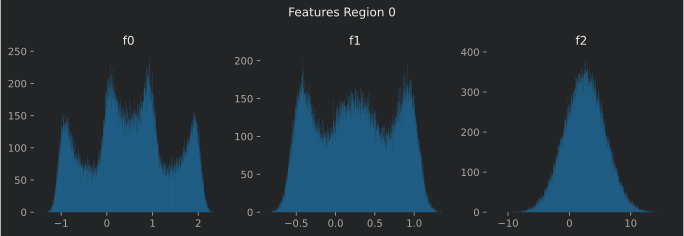

In [48]:
plot_hist(geo_data_zero, title='Features Region 0')

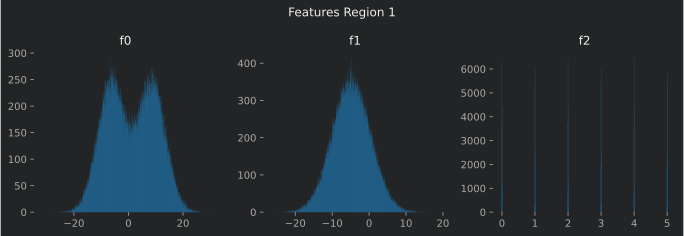

In [49]:
plot_hist(geo_data_one, title='Features Region 1')

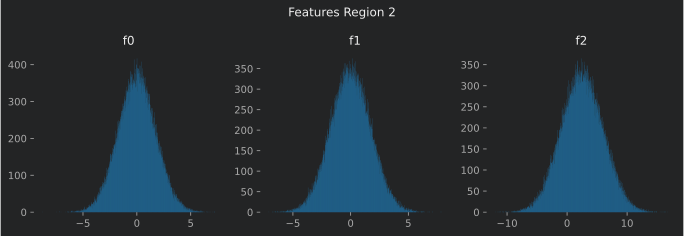

In [50]:
plot_hist(geo_data_two, title='Features Region 2')

- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три значимы признака точек
- `product` — объём запасов в скважине, (тыс. баррелей)

In [ ]:
display(
    geo_data_zero.info(),
    geo_data_zero.head()
)

In [ ]:
display(
    geo_data_one.info(),
    geo_data_one.head()
)

In [ ]:
display(
    geo_data_two.info(),
    geo_data_two.head()
)

<hr/>

## Обучите и проверьте модель для каждого региона

### Разбейте данные на обучающую и валидационную выборки в соотношении 75:25

### Обучите модель и сделайте предсказания на валидационной выборке

### Сохраните предсказания и правильные ответы на валидационной выборке

### Напечатайте на экране средний запас предсказанного сырья и RMSE модели

### Проанализируйте результаты

<hr/>

## Подготовьтесь к расчёту прибыли

### Все ключевые значения для расчётов сохраните в отдельных переменных

### Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины

### Сравните полученный объём сырья со средним запасом в каждом регионе

### Напишите выводы по этапу подготовки расчёта прибыли

### 

<hr/>

## Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выберите скважины с максимальными значениями предсказаний

### Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям

### Рассчитайте прибыль для полученного объёма сырья

### 

### 

<hr/>

## Посчитайте риски и прибыль для каждого региона

### Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков

#### Убыток — это отрицательная прибыль 

### Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор

### 

<hr/>

## 

## Как будут проверять мой проект?

- Как вы готовите данные к обучению?
- Выполнили все шаги по инструкции?
- Все ли условия бизнеса учтены?
- Какие выводы об исследовании задачи делаете?
- Корректно ли выполнена процедура Bootstrap?
- Предложен ли регион для разработки скважин? Обоснован ли выбор?
- Не дублируете ли код?
- Следите ли за структурой проекта и поддерживаете ли аккуратность кода?